In [1]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

In [2]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h2o_sto-3g_080222%000756.hdf5");
chemical_data = cdata_list[1]
PrintChemData(chemical_data)

Molecule name: h2o
Basis set: sto-3g
Molecular geometry: O 0.0 0.0 0.0; H 1.0 0.0 0.0; H 0.0 1.0 0.0; 
RHF energy: -74.96117113786774
FCI energy: -75.01927599660624


In [3]:
# Run a DMRG calculation (i.e. a single-state subspace):

dmrg1 = GenSubspace(chemical_data, 1, psi_maxdim=7, sweep_num=10, sweep_noise=(1e-6, 1e-7, 1e-8, 0.0));

dmrg1.ord_list = [collect(1:dmrg1.chem_data.N_spt)]

GenStates!(dmrg1, verbose=true);

GenPermOps!(dmrg1)

GenSubspaceMats!(dmrg1, verbose=true)

println("DMRG energy: ", dmrg1.H_mat[1,1] + dmrg1.chem_data.e_nuc)

dens = expect(dmrg1.psi_list[1],"Ntot")
println("Expected particle number: ", dmrg1.chem_data.N_el)
println("Particle number: ", sum(dens))


Generating states:
Progress: [1/1] 
Done!
DMRG energy: -75.014779008635
Expected particle number: 10
Particle number: 10.000000000000004


Generating states:
Progress: [13/13] 
Done!
Generating permutation operators:
Progress: [78/78] 
Done!

Minimum eigenvalue: -83.8471700715048
Condition number: 16795.980527596337
FCI energy: -75.01927599660624
Final energy estimate: -75.00614990249389
Best single ref. estimate: -74.99132739070154
Error: 0.013126094112351439
BSRfE: 0.027948605904697388
Improvement: 0.01482251179234595
Percentage error reduction: 53.03488783265106
Eigenvalue condition numbers: [0.0119, 0.012, 0.012, 0.012, 0.012, 0.0121, 0.0121, 0.0121, 0.0122, 0.0122, 0.0122, 0.0122, 0.0123]
Percent correlation energy with single-geometry DMRG: 51.89970940213734
Percent correlation energy with multi-geometry TNQE: 77.409644567893


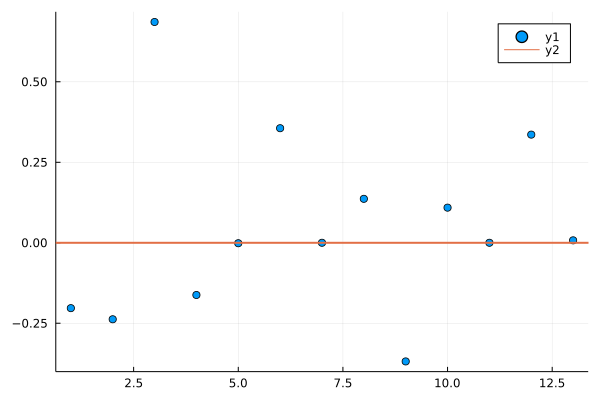

In [5]:
dmrg1a = GenSubspace(chemical_data, 13, psi_maxdim=3, sweep_num=6, sweep_noise=(1e-3));

dmrg1a.ord_list = [randperm(dmrg1a.chem_data.N_spt) for j=1:dmrg1a.mparams.M]

GenStates!(dmrg1a, verbose=true);

GenPermOps!(dmrg1a, verbose=true)

GenSubspaceMats!(dmrg1a, verbose=true)

SolveGenEig!(dmrg1a, thresh="inversion", verbose=true)

In [6]:
ScreenOrderings!(dmrg1a, maxiter=20, M_new=6, annealing=true, alpha=1e1, verbose=true);

computing matrix elements:
Progress: [91/91] 
Done!
Screening states (batch size = 6)
Progress: [20/20]; min. eval = -83.85884334243204 
Done!


In [7]:
GenPermOps!(dmrg1a, verbose=true)

Generating permutation operators:
Progress: [78/78] 
Done!



In [8]:
dmrg2a = copy(dmrg1a)

MultiGeomOptim!(
    dmrg2a, 
    sweeps=4, 
    maxiter=20000, 
    method="annealing",
    delta=1e-4,
    alpha=2e0,
    stun=true,
    gamma=1e8,
    noise=[1e-4,1e-5,1e-6,1e-8],
    verbose=true
)

In [9]:
println([maxlinkdim(dmrg2a.psi_list[j]) for j=1:dmrg2a.mparams.M])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


Minimum eigenvalue: -83.85999797850174
Condition number: 67173.34992502825
FCI energy: -75.01927599660624
Final energy estimate: -75.01897780949082
Best single ref. estimate: -74.98905965422766
Error: 0.0002981871154190685
BSRfE: 0.030216342378579952
Improvement: 0.029918155263160884
Percentage error reduction: 99.01315946290558
Eigenvalue condition numbers: [0.0119, 0.012, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0122, 0.0122, 0.0122, 0.0122, 0.0123, 0.0123]
Percent correlation energy with single-geometry DMRG: 47.996874900657225
Percent correlation energy with multi-geometry TNQE: 99.48681208096376


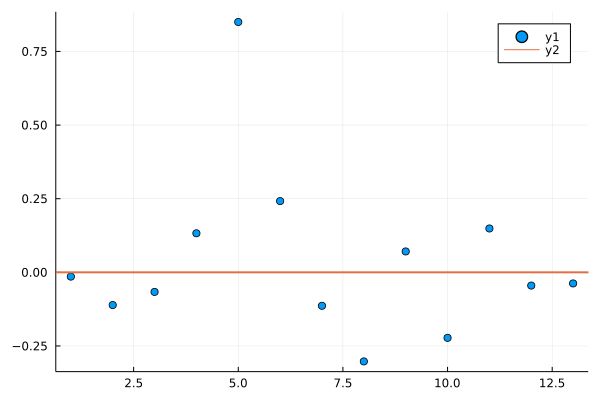

In [10]:
GenSubspaceMats!(dmrg2a, verbose=true)

SolveGenEig!(dmrg2a, thresh="inversion", verbose=true)

In [22]:
dmrg2b = copy(dmrg1a)

GenStates!(dmrg2b, verbose=true)

MultiGeomOptim!(
    dmrg2b, 
    sweeps=6, 
    maxiter=20000, 
    method="bboptim",
    delta=1e-4,
    alpha=2e0,
    stun=true,
    gamma=1e8,
    noise=[1e-5,1e-5,1e-5,1e-5,1e-6, 0.0],
    verbose=true
)

Generating states:
Progress: [13/13] 
Done!


In [23]:
println([maxlinkdim(dmrg2b.psi_list[j]) for j=1:dmrg2b.mparams.M])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


Minimum eigenvalue: -83.85988940475912
Condition number: 126.64086667882732
FCI energy: -75.01927599660624
Final energy estimate: -75.0188692357482
Best single ref. estimate: -74.95879508660539
Error: 0.0004067608580413662
BSRfE: 0.0604809100008481
Improvement: 0.06007414914280673
Percentage error reduction: 99.32745579053677
Eigenvalue condition numbers: [0.0119, 0.0121, 0.0121, 0.0121, 0.0121, 0.0122, 0.0122, 0.0122, 0.0122, 0.0123, 0.0124, 0.013, 0.0138]
Percent correlation energy with single-geometry DMRG: -4.0892471196577285
Percent correlation energy with multi-geometry TNQE: 99.29995379582289


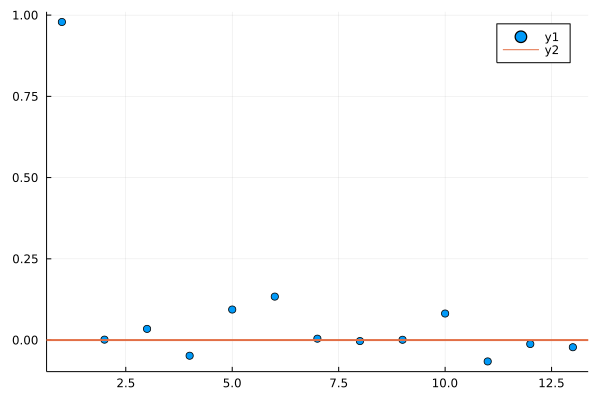

In [24]:
GenSubspaceMats!(dmrg2b, verbose=true)

SolveGenEig!(dmrg2b, thresh="inversion", verbose=true)

In [7]:
Ipq = MutualInformation(dmrg1.psi_list[1], dmrg1.chem_data, dim=4);

display(Ipq)

7×7 Matrix{Float64}:
 0.0         1.01108e-5   2.12588e-6   1.82142e-6  …  1.28966e-6  4.49462e-6
 1.01108e-5  0.0          0.00825121   0.0099386      0.0110516   0.00877771
 2.12588e-6  0.00825121   0.0          0.0312917      0.044919    0.0731323
 1.82142e-6  0.0099386    0.0312917    0.0            0.0477266   0.0311185
 8.19598e-7  0.000265293  0.000694486  0.00106625     0.00477855  0.000494173
 1.28966e-6  0.0110516    0.044919     0.0477266   …  0.0         0.0446667
 4.49462e-6  0.00877771   0.0731323    0.0311185      0.0446667   0.0

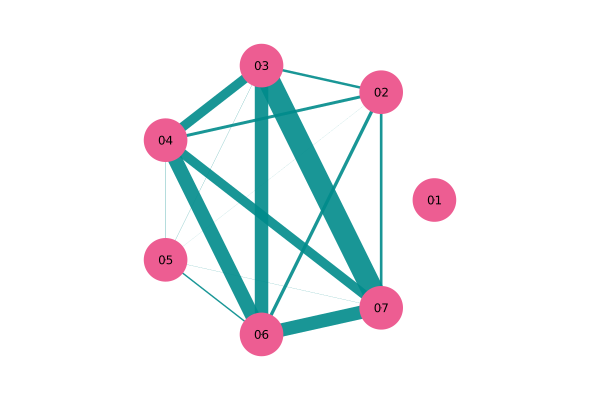

In [8]:
OrbitalGraphPlot(Ipq, multiplier=300)

[1, 5, 2, 4, 6, 3, 7]


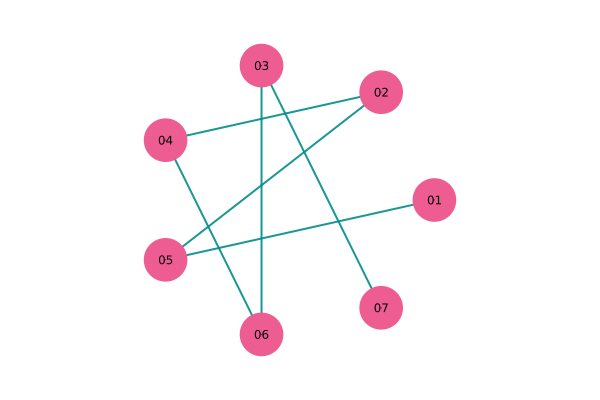

In [9]:
dmrg1.ord_list[1] = SimulatedAnnealing(Ipq, steps=1e4, tpow=5, swap_mult=3.0)

println(dmrg1.ord_list[1])

OrbitalGraphPlot(GraphMat(dmrg1.ord_list[1], directed=false), multiplier=2)

In [10]:
dmrg2 = GenSubspace(chemical_data, 1, psi_maxdim=7, sweep_num=10, sweep_noise=(1e-6, 1e-7, 1e-8, 0.0));


dmrg2.ord_list = [SimulatedAnnealing(Ipq, steps=1e4, tpow=5, swap_mult=3.0)]

GenStates!(dmrg2, verbose=true);

GenSubspaceMats!(dmrg2, verbose=true)

println("DMRG energy: ", dmrg2.H_mat[1,1] + dmrg2.chem_data.e_nuc)

Generating states:
Progress: [1/1] 
Done!
DMRG energy: -75.01887487914385


In [11]:
# Set up a TNQE calculation (i.e. a multi-state non-orthogonal subspace):

tnqe1 = GenSubspace(chemical_data, 10, psi_maxdim=3, sweep_num=4, sweep_noise=1e-3, thresh="projection", eps=1e-8);

ScreenOrderings!(tnqe1, maxiter=50, M_new=8, annealing=true, alpha=1e1, verbose=true);

computing matrix elements:
Progress: [55/55] 
Done!
Screening states (batch size = 8)


LoadError: InterruptException:

In [12]:
GenSubspaceMats!(tnqe1, verbose=true);

SolveGenEig!(tnqe1, thresh="inversion", verbose=true)

LoadError: BoundsError: attempt to access 0-element Vector{MPS} at index [1]

In [13]:

ex_sweeps = Sweeps(4)
maxdim!(ex_sweeps,tnqe1.mparams.psi_maxdim)
cutoff!(ex_sweeps,tnqe1.mparams.psi_tol)
setnoise!(ex_sweeps, 1e-1)

shadow1 = GenSubspaceShadow(tnqe1, 10, sweeps=ex_sweeps, weight=0.1, randomize=false, verbose=true);


Expanding subspaces:


LoadError: BoundsError: attempt to access 0-element Vector{Vector{Int64}} at index [1]

In [14]:
#shadow2 = copy(shadow1)
#BBOptimizeStates!(shadow2, loops=20, verbose=true)

shadow3 = copy(shadow1)

#tot_steps = 2e5
tot_loops = 1
#steps=floor(tot_steps/tot_loops)
steps1 = 100000
steps2 = 200000

delta_0 = 1e-2
alpha_0 = 0.7
gamma = 10.0

repeats = [20,20,20,20]


for k = 1:tot_loops
    
    k2 = sqrt(k)/tot_loops*10.0
    
    alpha = alpha_0*10^(k2/2)
    delta = delta_0/(10^(k2/4))
    for r=1:repeats[k]-1
        AnnealStates!(shadow3, maxiter=steps1, delta=delta, alpha=alpha, stun=true, gamma=gamma, verbose=true)
    end
    AnnealStates!(shadow3, maxiter=steps2, delta=delta, alpha=alpha, stun=true, gamma=gamma, verbose=true)
    println("")
    
end

LoadError: UndefVarError: shadow1 not defined

In [15]:
GenSubspaceMats!(shadow3);

SolveGenEig!(shadow3, thresh="inversion", verbose=true)

LoadError: UndefVarError: shadow3 not defined

In [16]:
bipartitions, entropies = ComputeBipartites(dmrg1, cuts=1000)

LoadError: InterruptException:

In [17]:
dmrg3 = copy(dmrg1)

println(dmrg3.ord_list[1])

dmrg3.ord_list = BipartiteAnnealing(
    dmrg3.ord_list, 
    bipartitions, 
    entropies, 
    maxiter=3000, 
    swap_mult=3.0, 
    alpha=5.0, 
    stun=true, 
    gamma=1e-1, 
    verbose=true
);

println("\n$(dmrg3.ord_list[1])")

[1, 5, 2, 4, 6, 3, 7]


LoadError: UndefVarError: bipartitions not defined

In [18]:
GenStates!(dmrg3, verbose=true);

GenSubspaceMats!(dmrg3, verbose=true)

println("DMRG energy: ", dmrg3.H_mat[1,1] + dmrg3.chem_data.e_nuc)

Generating states:
Progress: [1/1] 
Done!
DMRG energy: -75.0188756400378


In [19]:
tnqe4 = GenSubspace(chemical_data, 10, psi_maxdim=3, sweep_num=4, sweep_noise=1e-3, thresh="projection", eps=1e-8);

tnqe4.ord_list = [randperm(tnqe4.chem_data.N_spt) for j=1:tnqe4.mparams.M]

tnqe4.ord_list = BipartiteAnnealing(
    tnqe4.ord_list, 
    bipartitions, 
    entropies, 
    maxiter=500, 
    swap_mult=3.0, 
    alpha=1e2, 
    stun=true, 
    gamma=1e-1, 
    verbose=true
);

LoadError: UndefVarError: bipartitions not defined

In [20]:
println(tnqe4.ord_list)

[[7, 1, 2, 3, 5, 4, 6], [4, 6, 3, 7, 1, 2, 5], [2, 4, 1, 6, 7, 5, 3], [1, 3, 7, 2, 4, 5, 6], [2, 7, 3, 4, 5, 1, 6], [3, 2, 4, 6, 7, 5, 1], [5, 1, 2, 3, 6, 4, 7], [1, 6, 3, 4, 2, 5, 7], [4, 1, 3, 5, 2, 7, 6], [6, 3, 2, 1, 7, 5, 4]]


In [21]:
GenStates!(tnqe4,verbose=true);

Generating states:


LoadError: InterruptException:

In [22]:
GenSubspaceMats!(tnqe4,verbose=true);

SolveGenEig!(tnqe4, verbose=true)

LoadError: BoundsError: attempt to access 0-element Vector{MPS} at index [1]

In [23]:
tnqe5 = GenSubspace(chemical_data, 10, psi_maxdim=3, sweep_num=4, sweep_noise=1e-3, thresh="projection", eps=1e-8);

tnqe5.ord_list = [randperm(tnqe5.chem_data.N_spt) for j=1:tnqe5.mparams.M]

GenStates!(tnqe5, verbose=true)
GenSubspaceMats!(tnqe5, verbose=true)
SolveGenEig!(tnqe5, verbose=true)

Generating states:


LoadError: InterruptException:

In [24]:
using Profile
using ProfileVega

Profile.clear()
@profile MultiGeomOptim!(tnqe5, sweeps=1, verbose=true)

LoadError: InterruptException:

In [25]:
ProfileVega.view()

LoadError: InterruptException:

In [26]:
GenSubspaceMats!(tnqe5, verbose=true)
SolveGenEig!(tnqe5, verbose=true)

LoadError: BoundsError: attempt to access 0-element Vector{MPS} at index [1]